## Primary Goals:
Predict diabetes (binary classification)

## Assignment Specs:

- You need to explore multiple neural network models to solve this problem. You may use at most one model from earlier in our course, if you wish to see if neural networks can be beaten (I think this should be your best model from the heart disease lab).
- The kaggle page indicates that the the classes are unbalanced in this dataset (again). You should keep this in mind as you work and if appropriate, take steps to adjust for it. You may need to look up how to adjust for this yourself, but I could probably make some suggestions...as a starting place check out under- and oversampling ideas described here: https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/ . Feel free to explore neural network models on both the unbalanced and balanced data.
- Your submission should be built and written with non-experts as the target audience. All of your code should still be included, but do your best to narrate your work in accessible ways.

## Import Data

In [22]:
import pandas as pd
import os
import kagglehub

# Download path
path = kagglehub.dataset_download("alexteboul/diabetes-health-indicators-dataset")

# Full file path
file_path = os.path.join(path, "diabetes_binary_health_indicators_BRFSS2015.csv")

# Load into DataFrame
df = pd.read_csv(file_path)

df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


## Data Exploration and Cleaning

In [9]:
for col in df.columns:
    print(f"\nDistribution for '{col}':")
    print(df[col].value_counts(normalize=True).round(3).head())


Distribution for 'Diabetes_binary':
Diabetes_binary
0.0    0.861
1.0    0.139
Name: proportion, dtype: float64

Distribution for 'HighBP':
HighBP
0.0    0.571
1.0    0.429
Name: proportion, dtype: float64

Distribution for 'HighChol':
HighChol
0.0    0.576
1.0    0.424
Name: proportion, dtype: float64

Distribution for 'CholCheck':
CholCheck
1.0    0.963
0.0    0.037
Name: proportion, dtype: float64

Distribution for 'BMI':
BMI
27.0    0.097
26.0    0.081
24.0    0.077
25.0    0.068
28.0    0.065
Name: proportion, dtype: float64

Distribution for 'Smoker':
Smoker
0.0    0.557
1.0    0.443
Name: proportion, dtype: float64

Distribution for 'Stroke':
Stroke
0.0    0.959
1.0    0.041
Name: proportion, dtype: float64

Distribution for 'HeartDiseaseorAttack':
HeartDiseaseorAttack
0.0    0.906
1.0    0.094
Name: proportion, dtype: float64

Distribution for 'PhysActivity':
PhysActivity
1.0    0.757
0.0    0.243
Name: proportion, dtype: float64

Distribution for 'Fruits':
Fruits
1.0    0.634


### Some Concerns

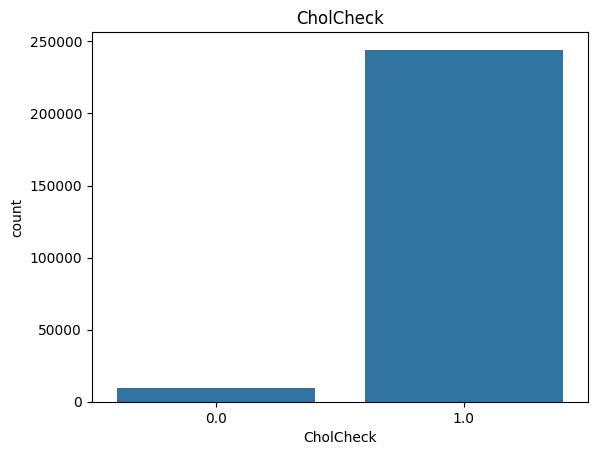

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='CholCheck', data=df)
plt.title('CholCheck')
plt.show()

Here we have a huge imbalance for the predictor checking 0 = no cholesterol check in 5 years 1 = yes cholesterol check in 5 years. From the imbalance and the fact that this predictor may be weak, we will drop this from the data frame.

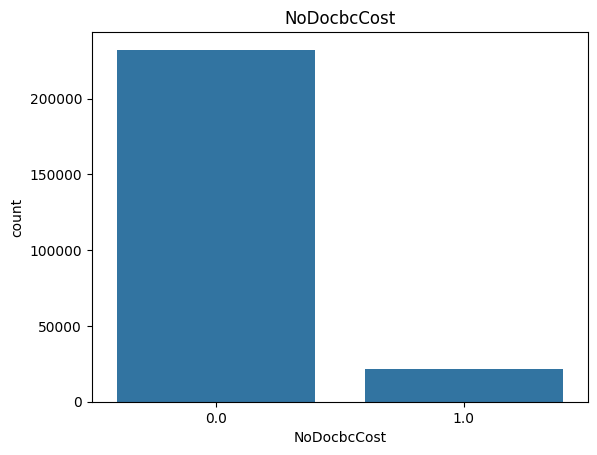

In [16]:
sns.countplot(x='NoDocbcCost', data=df)
plt.title('NoDocbcCost')
plt.show()

Here we see an overwhelming number of patients able to see a doctor. Since the majority of patients are not affected by this issue. We will drop it from the data frame.

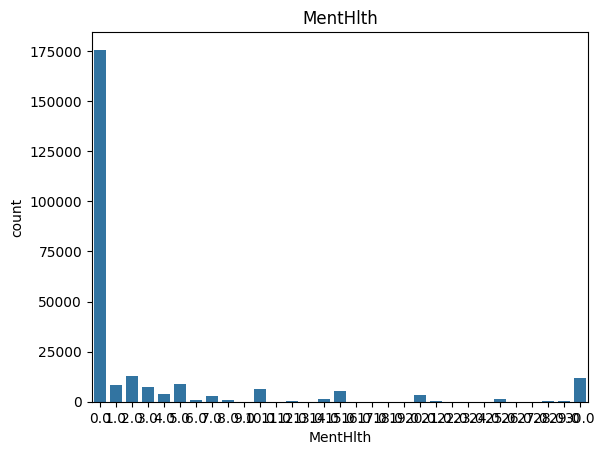

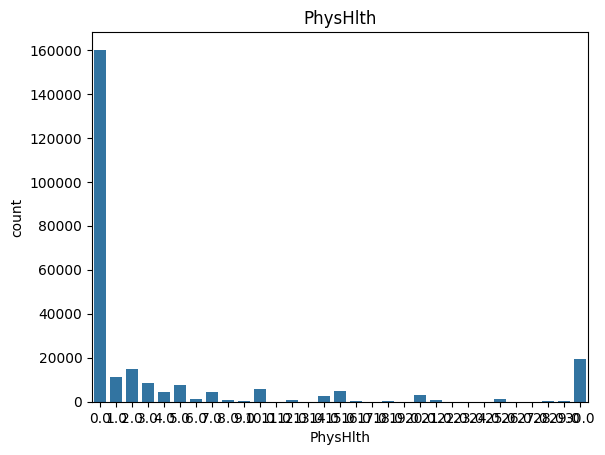

In [18]:
sns.countplot(x='MentHlth', data=df)
plt.title('MentHlth')
plt.show()

sns.countplot(x='PhysHlth', data=df)
plt.title('PhysHlth')
plt.show()

Another two variables with the majority of patients being unaffected are mental health, days of poor mental health scale 1-30 days, and physical health, physical illness or injury days in past 30 days scale 1-30. Because this is unimportant for the majority of patients we will drop them.

In [23]:
diabetes_df = df.drop(columns=["CholCheck", "NoDocbcCost", "MentHlth", "PhysHlth"])

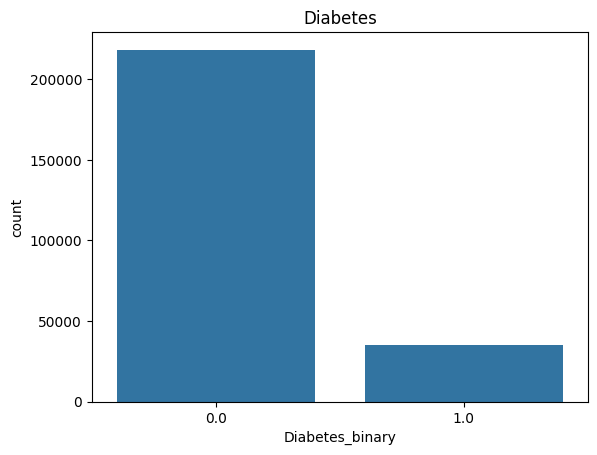

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example for a binary column
sns.countplot(x='Diabetes_binary', data=diabetes_df)
plt.title('Diabetes')
plt.show()

Of corse we see a huge imbalance with our target variable too. To counteract this we will use class weights as this is the best way to tell a neural network to look out for class imbalance without losing any data.

## Neural Network 1
### Setup

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import numpy as np

In [32]:
# Separate features and target
X = diabetes_df.drop(columns=['Diabetes_binary'])
y = diabetes_df['Diabetes_binary']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Compute class weights
# Ensure y_train is of int type
y_train = y_train.astype(int)

# Compute weights based on integer labels
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))


# 3. Build the Keras model
inputs = keras.Input(shape=(X_train_scaled.shape[1],))
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(inputs)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(16, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)  # Binary output

model = keras.Model(inputs=inputs, outputs=outputs, name="diabetes_classifier")

# 4. Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 5. Train the model
history = model.fit(
    X_train_scaled,
    y_train.values, # Use .values to turn into array, this way keras isn't confused by indexing
    batch_size=64,
    epochs=100,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    ],
    verbose=1,
    class_weight=class_weight_dict
)

# 6. Evaluate the model
scores = model.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Test Loss: {scores[0]}")
print(f"Test Accuracy: {scores[1]}")

# 7. Predict and report performance
y_pred_probs = model.predict(X_test_scaled).flatten()
y_pred_classes = (y_pred_probs > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

Epoch 1/100
2537/2537 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.6892 - loss: 0.5695 - val_accuracy: 0.7076 - val_loss: 0.5267
Epoch 2/100
2537/2537 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7061 - loss: 0.5272 - val_accuracy: 0.7176 - val_loss: 0.5009
Epoch 3/100
2537/2537 ━━━━━━━━━━━━━━━━━━━━ 45s 18ms/step - accuracy: 0.7128 - loss: 0.5220 - val_accuracy: 0.7093 - val_loss: 0.5331
Epoch 4/100
2537/2537 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - accuracy: 0.7126 - loss: 0.5165 - val_accuracy: 0.7028 - val_loss: 0.5254
Epoch 5/100
2537/2537 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.7093 - loss: 0.5178 - val_accuracy: 0.7099 - val_loss: 0.5100
Epoch 6/100
2537/2537 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.7047 - loss: 0.5199 - val_accuracy: 0.6910 - val_loss: 0.5333
Epoch 7/100
2537/2537 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.7026 - loss: 0.5224 - val_accuracy: 0.7114 - val_loss: 0.4870
Epoch 8/100
2537/2537 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.704

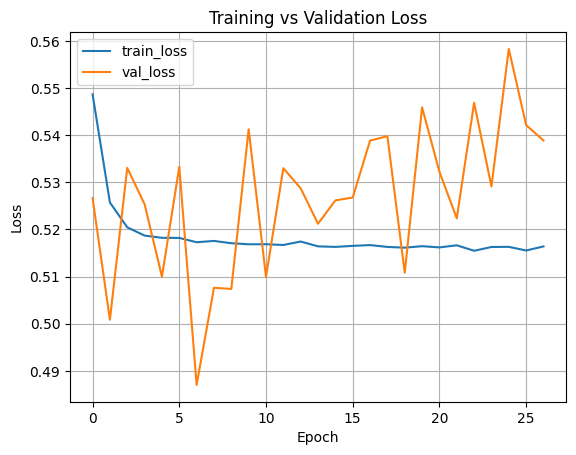

In [33]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

The graph shows the training loss (blue) and validation los
(orange) over the course of training epochs. While the training loss steadily decreases which we hope to see in order to verify teh model is learning at each stage, the validation loss fluctuates significantly and trends upward over time. This behavior indicates that the model is overfitting. 

It is learning the training data well but failing to generalize to new, unseen data. The widening gap between the two loss curves suggests the model is becoming too specialized to the training data, which harms its ability to make accurate predictions on validation  samples, eventhough teh accuracy is not bad.

## Neural Network 2

To improve generalization and reduce overfitting, we're simplifying and regularizing the model. We’ve reduced the number of dense layers and neurons to make the architecture less complex, increased L2 regularization strength to penalize large weights, and raised the dropout rate to reduce reliance on specific neurons. Batch normalization layers have been added to stabilize and speed up training. Additionally, we’ve lowered the learning rate to allow for more controlled updates during optimization. These changes collectively aim to make the model more robust and better suited for making accurate predictions on new data.

In [35]:
from tensorflow import keras
from keras import layers, regularizers

# 3. Build the improved Keras model
inputs = keras.Input(shape=(X_train_scaled.shape[1],))

# Dense layer 1
x = layers.Dense(32, kernel_regularizer=regularizers.l2(0.01))(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.4)(x)

# Dense layer 2
x = layers.Dense(16, kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.4)(x)

# Output layer
outputs = layers.Dense(1, activation='sigmoid')(x)  # Binary output

model = keras.Model(inputs=inputs, outputs=outputs, name="improved_diabetes_classifier")

# 4. Compile the model with reduced learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 5. Train the model
history = model.fit(
    X_train_scaled,
    y_train.values,
    batch_size=64,
    epochs=100,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    ],
    verbose=1,
    class_weight=class_weight_dict
)


Epoch 1/100
2537/2537 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.5925 - loss: 0.8752 - val_accuracy: 0.6908 - val_loss: 0.5635
Epoch 2/100
2537/2537 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6932 - loss: 0.5588 - val_accuracy: 0.7106 - val_loss: 0.5126
Epoch 3/100
2537/2537 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6963 - loss: 0.5442 - val_accuracy: 0.6947 - val_loss: 0.5272
Epoch 4/100
2537/2537 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6940 - loss: 0.5422 - val_accuracy: 0.7110 - val_loss: 0.5094
Epoch 5/100
2537/2537 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6991 - loss: 0.5360 - val_accuracy: 0.7119 - val_loss: 0.5239
Epoch 6/100
2537/2537 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6998 - loss: 0.5376 - val_accuracy: 0.7041 - val_loss: 0.5095
Epoch 7/100
2537/2537 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6992 - loss: 0.5364 - val_accuracy: 0.7052 - val_loss: 0.5291
Epoch 8/100
2537/2537 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6996 - lo

In [37]:
scores = model.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Test Loss: {scores[0]}")
print(f"Test Accuracy: {scores[1]}")

# 7. Predict and report performance
y_pred_probs = model.predict(X_test_scaled).flatten()
y_pred_classes = (y_pred_probs > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

1586/1586 - 3s - 2ms/step - accuracy: 0.7139 - loss: 0.5069
Test Loss: 0.5069464445114136
Test Accuracy: 0.7138915061950684
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     43739
         1.0       0.30      0.81      0.44      6997

    accuracy                           0.71     50736
   macro avg       0.63      0.75      0.62     50736
weighted avg       0.87      0.71      0.76     50736



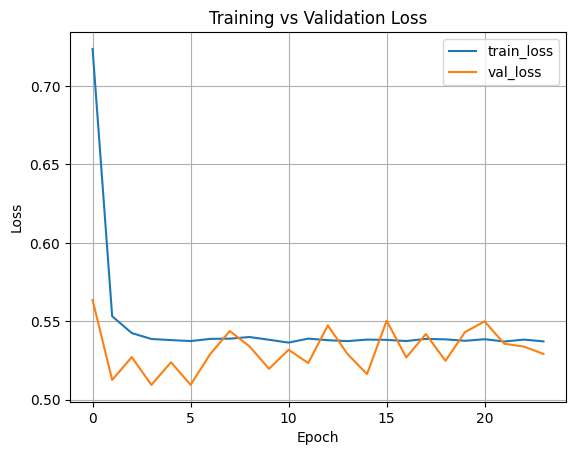

In [36]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

This updated training vs. validation loss graph shows a significant improvement in model behavior. Both the training and validation loss curves decrease initially and then stabilize around similar values, with much less divergence than before. The validation loss no longer trends upward, and the fluctuations are minor and expected. This suggests that overfitting has been effectively reduced. The model is not only learning the training data but also generalizing better to unseen data. Although the final accuracy metric hasn't improved, this plot indicates healthier, more stable learning and a model that is more reliable.

Now lets investigate a different model to compare neural networks.

## XGBoost

In [39]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Train one XGBoost model
model = XGBClassifier(n_estimators= 200, learning_rate= 0.1)
model.fit(X_train, y_train)

# Predict
pred = model.predict(X_test)

# Evaluate
acc = accuracy_score(y_test, pred)
print(f"Accuracy: {acc:.4f}")

print(classification_report(y_test, pred))

Accuracy: 0.8684
              precision    recall  f1-score   support

         0.0       0.88      0.98      0.93     43739
         1.0       0.58      0.17      0.26      6997

    accuracy                           0.87     50736
   macro avg       0.73      0.57      0.59     50736
weighted avg       0.84      0.87      0.84     50736



## Conclusion

While we explored several neural network architectures, we found that tree-based boosting methods like XGBoost significantly outperformed them; achieving an accuracy of 86% compared to the neural network's 78%. This is because the dataset contains structured information which boosting models are especially well-suited for. Neural networks are more effective on large, complex datasets. So in this case, we concluded that boosting was the best modeling approach.